In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from utils.make_dataset import *
from utils.transforms import *
from detection.detector_utils import *

import cv2
from glob import glob
import os
import re
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import json, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.data import transforms as T

import glob
from PIL import Image, ImageDraw


Populating the interactive namespace from numpy and matplotlib


In [2]:
DatasetImages = PreprocessedDatasetPart1()

#data_list_Light = DatasetImages.make_in_memory_dataset(task, projection, researh_types, drop_types, crop=True, best_slice=True, resize=False ):
#data_list_FS = DatasetImages.make_in_memory_dataset(task, projection, researh_types, drop_types, crop=True, best_slice=True, resize=False ):
    
data_list_Full = DatasetImages.make_in_memory_dataset('ill', 'cor', ['PD', 'T1', 'T2', 'STIR',], drop_types = ['DIRTY'] , crop=False, best_slice=False, resize=False ,stack_images=False)

DATASET_NAME = 'joints_large_Full'
DATASET_PATH = 'detection/data/cor'
MODEL_NAME = 'Detector_LARGE_UNI.pth'

368  dataset length


In [3]:
data_list = data_list_Full

(208, 160)


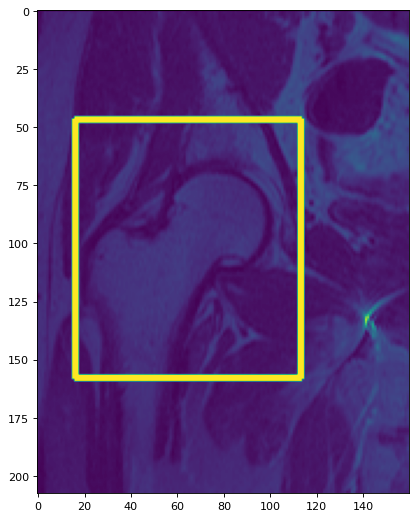

In [4]:
i = 11
images = data_list[i]['images']
path = data_list[i]['path']
best_slice = data_list[i]['best_slice']   
box = np.array(data_list[i]['box'])
image = images[best_slice].copy()
print(image.shape)

color = (255, 0, 0)  
thickness = 2  
image = cv2.rectangle(image,  (box[0], box[1]) , (box[2],box[3]),  color, thickness)
figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(image)
plt.show()

In [5]:
def dataset_format_train():    
    dataset = dataset_train       
    return dataset    

def dataset_format_val():    
    dataset = dataset_val       
    return dataset    

def dataset_format_train_FS():    
    dataset = dataset_train_FS       
    return dataset    

def dataset_format_val_FS():    
    dataset = dataset_val_FS       
    return dataset    

In [6]:
dataset_train, dataset_val = make_jpeg_dataset(data_list, base_path = DATASET_PATH)


In [7]:
DatasetCatalog.register(DATASET_NAME + "_train", dataset_format_train)
DatasetCatalog.register(DATASET_NAME + "_val", dataset_format_val) 

MetadataCatalog.get(DATASET_NAME + "_train").thing_classes = ["joint"]
MetadataCatalog.get(DATASET_NAME + "_val").thing_classes = ["joint"]

joints_metadata = MetadataCatalog.get(DATASET_NAME + "_train")

In [12]:
#DatasetCatalog.remove(DATASET_NAME + "_train")
#DatasetCatalog.remove(DATASET_NAME + "_val")

#!rm detection/data/cor/*.jpg

In [20]:
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader

class Trainer(DefaultTrainer):

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations= [
                                                                      T.RandomBrightness(0.8, 1.2),
                                                                      #T.HFlipTransform(), 
                                                                                                          ], 
                                                                      
                                                                     )
                                            )

In [22]:
#detection/model_final_971ab9.pkl
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Base-RetinaNet.yaml"))
cfg.DATASETS.TRAIN = (DATASET_NAME + "_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 10
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00015  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Loading config /home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/detectron2/model_zoo/configs/Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


NameError: name 'DATASET_NAME' is not defined

In [18]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

<ipython-input-19-94157b67c64e>:11: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  image = cv2.rectangle(im,  (pred_boxes[0], pred_boxes[1]) , (pred_boxes[2],pred_boxes[3]),  color, thickness)


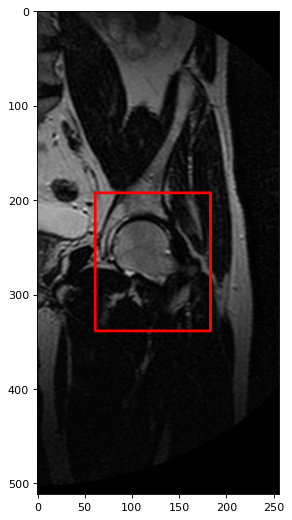

[ 61.166183 193.56227  183.36598  339.0026  ]


In [19]:
from detectron2.utils.visualizer import ColorMode
color = (255, 0, 0)  
thickness = 2  
dataset_dicts = dataset_val

for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    pred_boxes = outputs["instances"].to("cpu").pred_boxes[0].tensor.numpy()[0]
    
    image = cv2.rectangle(im,  (pred_boxes[0], pred_boxes[1]) , (pred_boxes[2],pred_boxes[3]),  color, thickness)
    figure(figsize=(8, 8), dpi=80)
    imgplot = plt.imshow(image)
    plt.show()

    print(pred_boxes)

## Small Crop

In [4]:
annotation_path = 'detection/Smal_Crop/annotations.json'

with open(annotation_path) as json_file:
    annotation_data = json.load(json_file)
print('masks: ',len(list(annotation_data.keys())))
filenames_list = glob.glob('detection/Smal_Crop/images/*.png')
print('images: ', len(filenames_list))

masks:  361
images:  363


In [5]:
def get_box(box):    
    
    startX = box['x1']
    startY = box['y1'] 
    endX = box['x2']
    endY  = box['y2']
    box = [startX, startY, endX, endY]
    
    return box  

      
def resize_new_box(orginal_image, old_box, box):     
    
    startX, startY, endX, endY = box
    startX -= old_box[0]
    endX -= old_box[0]
    startY -= old_box[1]
    endY -= old_box[1]
    resized_box = [startX, startY, endX, endY]    
    
    return resized_box

def get_npy_file(element, path = './data'):  
    
    name = element['path'].split('/')[-1].split('.')[0]
    npy_file_path = os.path.join(path,name + '.npy')
    images = np.load(npy_file_path, allow_pickle=True)
    
    return images, npy_file_path  


In [6]:
crops_dataset_raw = {}

for file in filenames_list:
    png_name = file.split('/')[-1]
    if png_name in list(annotation_data.keys()):
        element = {}
        orig_image = Image.open(file)
        width, height = orig_image.size
        img = Image.new('L', (width, height), 0)
        instances = annotation_data[png_name]['instances']
        for instance in instances:
            box = get_box(instance['points'])
        element['box'] = box
        element['path'] = file
        element['image'] = orig_image
        _ , npy_path = get_npy_file(element)
        
        crops_dataset_raw[npy_path] = element      


In [7]:

                                               
    
def prepare_detection_dataset(crops_dataset_raw, projection, task, drop_researh_tags=['DIRTY'], researh_type=None, conjunction=True, resize=True, dim=(256, 256),best_slice = False, with_images = False):
    
    marking = pd.read_csv('labels/marking_arrays_v2.csv', usecols=['path', 'parent path', 'patient number',
                                                                'researh type', 'projection', 'hip side',
                                                                'cartialge lesion',
                                                                'subchondral cysts', 'bone marrow lesion', 'synovitis',
                                                                'ill', 'best_slice', 'bad_research', 'rectangle'])
    

    bad_mark = '-'
    proc_marking = marking[marking['bad_research'] != bad_mark]
    proc_marking = proc_marking[proc_marking['projection'] == projection]
    if researh_type:
        if conjunction:
            proc_marking_1 = proc_marking[proc_marking['researh type'].str.contains(researh_type[0], na=False)]
            proc_marking_2 = proc_marking[proc_marking['researh type'].str.contains(researh_type[1], na=False)]
            proc_marking_3 = proc_marking[proc_marking['researh type'].str.contains(researh_type[2], na=False)]
            proc_marking  = pd.concat([proc_marking_1, proc_marking_2,  proc_marking_3])
            proc_marking = proc_marking.drop_duplicates()
        elif not conjunction:  
            proc_marking = proc_marking[proc_marking['researh type'].str.contains(researh_type[0], na=False) & proc_marking['researh type'].str.contains(researh_type[1], na=False)]


    for tag in drop_researh_tags:
        mask = proc_marking['researh type'].str.contains(tag, na=False)
        proc_marking = proc_marking[~mask]

    data_dict = {}
    length = 0
    new_keys = list(crops_dataset_raw.keys())
    
    for i, row in enumerate(proc_marking.iloc):
        label = {}
        data = {}

        path = row['path']
        raw_row = row['rectangle']
        box = re.findall(r"\d+", raw_row)
        integer_map = map(int, box)
        box = list(integer_map)
        try:
            images = np.load(path[2:], allow_pickle=True)
        except ValueError:
            print('not loaded ', path)
        else:
            if len(images.shape )>2:

                data['label'] = int(row[task])
                
                if path in new_keys:
                    new_box = crops_dataset_raw[path]['box']                
                    data['bb_box'] = new_box
                    data['bb_box_large'] = box
                else:
                    continue
                    
                
                
                if best_slice:                    
                    slice = int(row['best_slice'])
                    images = slice_crop(images, 0.1, slice)
                if resize:
                    images = resize_cv2(images, dim)

                images = normalize_images_v1(images)     
                
                
                #data['image'] = images
                data['image'] = crop_images(images, box)
                data['bb_box'] = resize_new_box(images, box, data['bb_box'] )
                
                data['path'] = path
                data['best_slice'] = int(row['best_slice'])
                data_dict[path] = data                
                length += 1
                
    print('dataset len', length)
    assert len(list(data_dict.keys()))==length
    return length, data_dict

In [8]:
_, data_dict = prepare_detection_dataset(crops_dataset_raw, 'cor', 'ill',
                             drop_researh_tags=['DIRTY'],
                             researh_type=['PD', 'T1', 'T2', 'STIR'], 
                             conjunction=True, resize=False,
                             dim=(512, 512), best_slice = False, with_images = True )

dataset len 330


(144, 127)


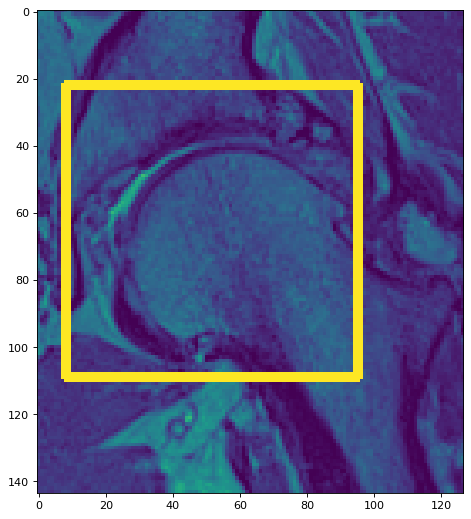

[  8.83772278  22.60296631  95.19999695 109.80000305]


In [9]:
i = 4
keys = list(data_dict.keys())
key = keys[i]
images = data_dict[key]['image']
path = data_dict[key]['path']
best_slice = data_dict[key]['best_slice']   
box = np.array(data_dict[key]['bb_box'])
#box_large = np.array(data_dict[key]['bb_box_large'])

image = images[best_slice].copy()
print(image.shape)

color = (255, 0, 0)  
thickness = 2  
image = cv2.rectangle(image,  (int(box[0]), int(box[1])) , (int(box[2]),int(box[3])),  color, thickness)
#image = cv2.rectangle(image,  (int(box_large[0]), int(box_large[1])) , (int(box_large[2]),int(box_large[3])),  color, thickness)

figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(image)
plt.show()
print(box)

In [21]:
def make_jpeg_dataset(data_dict):
    base_path = 'detection/data/cor/'
    index = 0    
    keys = list(data_dict.keys())
    dataset_train = []
    for key in keys[:int(len(keys)*0.9)]:
        
        images = data_dict[key]['image']        
        best_slice = data_dict[key]['best_slice']   
        bbox = {'bbox': data_dict[key]['bb_box'], 'bbox_mode': BoxMode.XYXY_ABS, 'category_id':0}     
        for i in [-2,-1,0,1, 2]:
            
            element = dict()
            current_slice = best_slice+i
            if current_slice<0:
                current_slice =0
            image = images[current_slice]        
            filename = os.path.join(base_path, '{}_slice.jpg'.format(index))        
            cv2.imwrite(filename, image)
            element['file_name'] = filename
            element['height'] = image.shape[0]
            element['width'] = image.shape[1]
            element['image_id'] = index 
            element['annotations'] = []    
               
            element['annotations'].append(bbox)
            dataset_train.append(element)
            index += 1
            
    dataset_val = []
    for key in keys[int(len(keys)*0.9):]:
        
        images = data_dict[key]['image']        
        best_slice = data_dict[key]['best_slice']   
        bbox = {'bbox': data_dict[key]['bb_box'], 'bbox_mode': BoxMode.XYXY_ABS, 'category_id':0}     
        for i in [-1,0,1]:
            
            element = dict()
            current_slice = best_slice+i
            if current_slice<0:
                current_slice =0
            image = images[current_slice]        
            filename = os.path.join(base_path, '{}_slice.jpg'.format(index))        
            cv2.imwrite(filename, image)
            element['file_name'] = filename
            element['height'] = image.shape[0]
            element['width'] = image.shape[1]
            element['image_id'] = index 
            element['annotations'] = []    
               
            element['annotations'].append(bbox)
            dataset_val.append(element)
            index += 1

    return dataset_train, dataset_val

In [22]:
def dataset_format_example():
    
    keys = list(data_dict.keys())
    dataset = []
    i = 0
    for key in keys:
        i += 1
        element = dict()
        element['file_name'] = data_dict[key]['path']
        element['height'] = data_dict[key]['image'].shape[0]
        element['width'] = data_dict[key]['image'].shape[1]
        element['image_id'] = i        
        element['annotations'] = []        
        bbox = {'bbox': data_dict[key]['bb_box'], 'bbox_mode': BoxMode.XYXY_ABS, 'category_id':0}
        
        element['annotations'].append(bbox)
        dataset.append(element)
        
    return dataset    

def dataset_format_train():    
    dataset = dataset_train       
    return dataset    

In [23]:
DatasetCatalog.remove("joints_train")


In [24]:
dataset_train, dataset_val = make_jpeg_dataset(data_dict)

DatasetCatalog.register("joints_train", dataset_format_train)

#data = DatasetCatalog.get("joints_train")

from detectron2.data import MetadataCatalog

MetadataCatalog.get("joints_train").thing_classes = ["joint"]

joints_metadata = MetadataCatalog.get("joints_train")

In [25]:
from detectron2.engine import DefaultTrainer
#detection/model_final_971ab9.pkl
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Base-RetinaNet.yaml"))
cfg.DATASETS.TRAIN = ("joints_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 6
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00015  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Loading config /home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/detectron2/model_zoo/configs/Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[07/10 21:29:51 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  backbone.bottom_up.res4.6.conv1.weight
  backbone.bottom_up.res4.6.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.6.conv2.weight
  backbone.bottom_up.res4.6.conv2.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.6.conv3.weight
  backbone.bottom_up.res4.6.conv3.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.7.conv1.weight
  backbone.bottom_up.res4.7.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.7.conv2.weight
  backbone.bottom_up.res4.7.conv2.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.7.conv3.weight
  backbone.bottom_up.res4.7.conv3.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.8.conv1.weight
  backbone.bottom_up.res4.8.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.8.conv2.weight
  backbo

[07/10 21:29:51 d2.engine.train_loop]: Starting training from iteration 0


/home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[07/10 21:30:06 d2.utils.events]:  eta: 0:12:24  iter: 19  total_loss: 1.651  loss_cls: 1.047  loss_box_reg: 0.5798  time: 0.7606  data_time: 0.0088  lr: 2.9971e-06  max_mem: 3995M
[07/10 21:30:17 d2.utils.events]:  eta: 0:10:30  iter: 39  total_loss: 1.373  loss_cls: 0.7551  loss_box_reg: 0.6216  time: 0.6464  data_time: 0.0019  lr: 5.9941e-06  max_mem: 3995M
[07/10 21:30:27 d2.utils.events]:  eta: 0:08:51  iter: 59  total_loss: 1.02  loss_cls: 0.4453  loss_box_reg: 0.593  time: 0.6019  data_time: 0.0019  lr: 8.9911e-06  max_mem: 3995M
[07/10 21:30:37 d2.utils.events]:  eta: 0:08:11  iter: 79  total_loss: 0.811  loss_cls: 0.3626  loss_box_reg: 0.4558  time: 0.5687  data_time: 0.0019  lr: 1.1988e-05  max_mem: 3995M
[07/10 21:30:47 d2.utils.events]:  eta: 0:07:49  iter: 99  total_loss: 0.6414  loss_cls: 0.292  loss_box_reg: 0.3241  time: 0.5571  data_time: 0.0019  lr: 1.4985e-05  max_mem: 4659M
[07/10 21:30:57 d2.utils.events]:  eta: 0:07:33  iter: 119  total_loss: 0.5951  loss_cls: 0.2

In [26]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

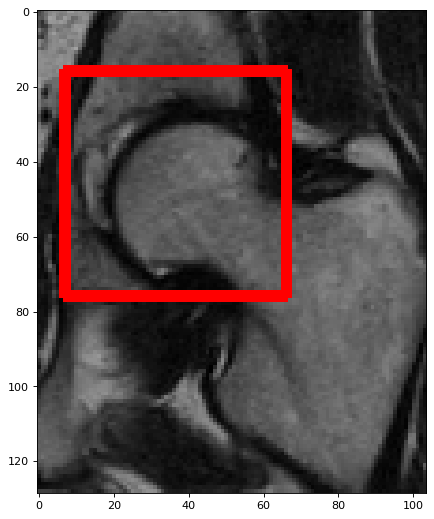

[ 7 16 66 76]


In [54]:
from detectron2.utils.visualizer import ColorMode
color = (255, 0, 0)  
color2 = (0, 255, 0)  

thickness = 2  
dataset_dicts = dataset_train

for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    pred_boxes = np.uint8(outputs["instances"].to("cpu").pred_boxes[0].tensor.numpy()[0])
    pred_boxes2 = np.uint8(outputs["instances"].to("cpu").pred_boxes[1].tensor.numpy()[0])

    image = cv2.rectangle(im,  (pred_boxes[0], pred_boxes[1]) , (pred_boxes[2],pred_boxes[3]),  color, thickness)
    #image = cv2.rectangle(im,  (pred_boxes2[0], pred_boxes2[1]) , (pred_boxes2[2],pred_boxes2[3]),  color2, thickness)

    figure(figsize=(8, 8), dpi=80)
    imgplot = plt.imshow(image)
    plt.show()

    print(pred_boxes)

In [40]:
outputs

{'instances': Instances(num_instances=6, image_height=140, image_width=112, fields=[pred_boxes: Boxes(tensor([[  7.1235,  10.3329,  74.5753,  77.0253],
         [ 11.3832,  20.9439,  90.2324, 103.6929],
         [  7.6911,   9.4216,  74.6160,  77.1065],
         [  7.8371,  11.3698,  74.9776,  78.7031],
         [ 66.0960,  14.5078, 110.8751,  59.8460],
         [ 19.9721,  66.2002,  92.8400, 140.0000]], device='cuda:0')), scores: tensor([0.9801, 0.1273, 0.0959, 0.0637, 0.0594, 0.0574], device='cuda:0'), pred_classes: tensor([ 0,  0, 15, 77,  0,  0], device='cuda:0')])}